In [ ]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#IMPORT LIBRARY OF SEGMENTATION

import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.morphology import extrema
from skimage.segmentation import watershed

In [ ]:


def ShowImage(title, img, ctype):
    plt.figure(figsize=(10, 10))      #SET THE FIGURE SIZE TO 10X10 INCHES
    if ctype == 'bgr':
        b, g, r = cv2.split(img)       #SPLIT IMAGE INTO B,G,R
        rgb_img = cv2.merge([r, g, b])     #MERGE THE CHANNEL IN R,G,B ORDER
        plt.imshow(rgb_img)
    elif ctype == 'hsv':
        rgb = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)    #CONVERT IMAGE HSV TO RGB(HUE,SATURATION,VALUE)
        plt.imshow(rgb)
    elif ctype == 'gray':
        plt.imshow(img, cmap='gray')        #DISPLAY IN GRAY SCALE FORMAT
    elif ctype == 'rgb':
        plt.imshow(img)                     #DISPLAY IN RGB FORMAT
    else:
        raise Exception("Unknown colour type")
    plt.axis('off')
    plt.title(title)
    plt.show()



In [ ]:
'''

  ^ABOVE CODE'S EXPLAINATION

     ->>converting from HSV to RGB is essential for correctly displaying images on most screens
          and for compatibility with image processing tools that expect RGB input.

     ->>When you perform color detection, object recognition, or any operation where
         color characteristics are essential, you might work with an image in the HSV
         color space to easily manipulate the hue and saturation. However, when
         displaying the result or further processing it with common image libraries,
         you typically convert it back to RGB.

'''


"\n\n  ^ABOVE CODE'S EXPLAINATION\n\n     ->>converting from HSV to RGB is essential for correctly displaying images on most screens\n          and for compatibility with image processing tools that expect RGB input.\n\n     ->>When you perform color detection, object recognition, or any operation where\n         color characteristics are essential, you might work with an image in the HSV\n         color space to easily manipulate the hue and saturation. However, when\n         displaying the result or further processing it with common image libraries,\n         you typically convert it back to RGB.\n\n"

In [ ]:
from google.colab import files
from PIL import Image
import io

# Upload the image file
uploaded = files.upload()

# Check if an image was uploaded
if uploaded:
    image_path = next(iter(uploaded))
    image = Image.open(io.BytesIO(uploaded[image_path]))
    print(f"Image {image_path} uploaded successfully!")
else:
    print("No image uploaded, exiting...")
    exit()




Saving Tr-no_0018.jpg to Tr-no_0018.jpg
Image Tr-no_0018.jpg uploaded successfully!


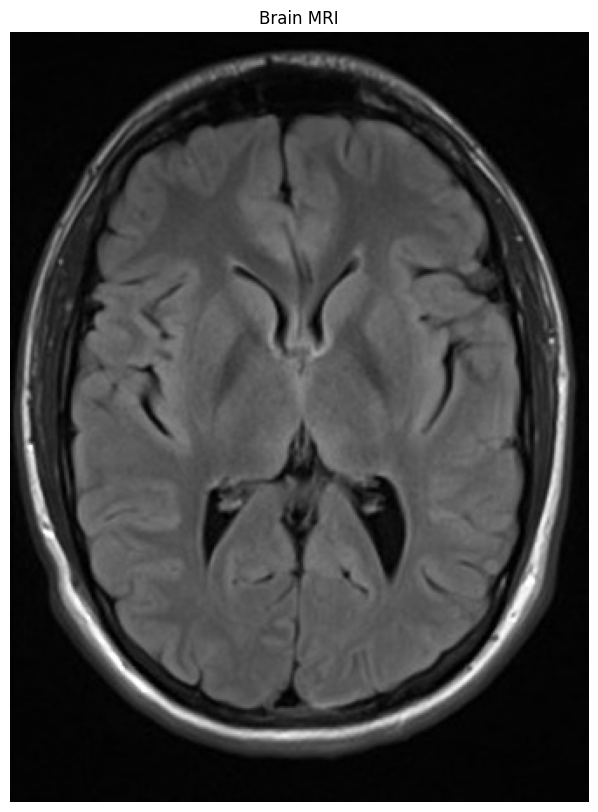

In [ ]:
# READ THE IMAGE THAT WE HAVE UPLOADED

img = cv2.imread(image_path)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)



ShowImage('Brain MRI', gray, 'gray')

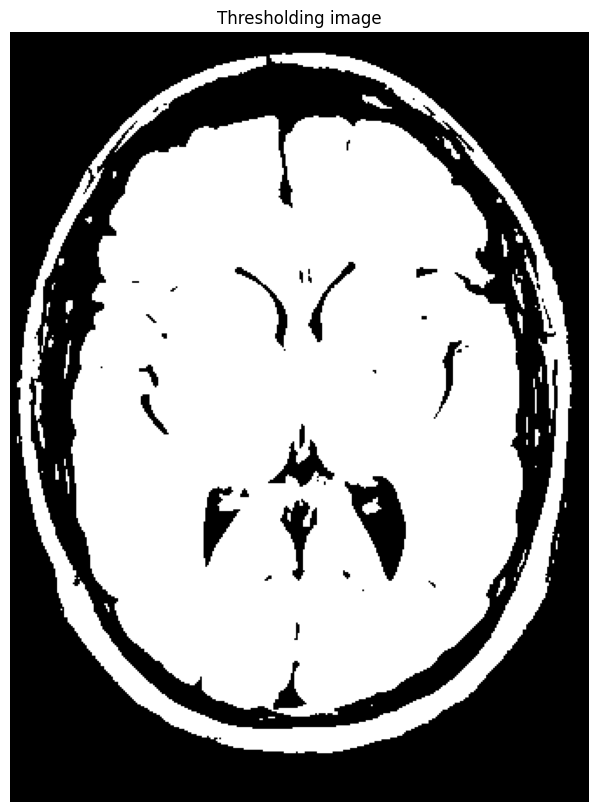

In [ ]:
# THRESHOLDING USING OTSU'S METHOD

# OTSU'S METHOD AUTOMATICALLY CALCULATES THE OPTIMAL THRESHOLD VALUE TO SEPARATE THE FOREGROUND AND BACKGROUND
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)

# DISPLAY THE THRESHOLDED IMAGE
ShowImage('Thresholding image', thresh, 'gray')



In [ ]:
# CONNECTED COMPONENTS ANALYSIS

# THIS STEP LABELS DIFFERENT CONNECTED COMPONENTS IN THE BINARY IMAGE. EACH CONNECTED COMPONENT GETS A UNIQUE LABEL.
ret, markers = cv2.connectedComponents(thresh)

# CALCULATE THE AREA TAKEN BY EACH COMPONENT, EXCLUDING THE BACKGROUND (LABEL 0)
marker_area = [np.sum(markers == m) for m in range(np.max(markers)) if m != 0]

# IDENTIFY THE LABEL OF THE LARGEST CONNECTED COMPONENT
largest_component = np.argmax(marker_area) + 1  # ADD 1 BECAUSE LABEL 0 IS BACKGROUND

# CREATE A MASK FOR THE LARGEST CONNECTED COMPONENT (WHICH CORRESPONDS TO THE BRAIN IN THIS CONTEXT)
brain_mask = markers == largest_component

# CREATE A COPY OF THE ORIGINAL IMAGE TO APPLY THE BRAIN MASK
brain_out = img.copy()

# REMOVE ALL REGIONS FROM THE IMAGE EXCEPT FOR THE LARGEST COMPONENT (BRAIN)
brain_out[brain_mask == False] = (0, 0, 0)


In [ ]:
# NOISE REMOVAL

img = cv2.imread(image_path)#READ THE IMAGE PATH


gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # CONVERT THE IMAGE TO GRAYSCALE

# APPLY INVERSE BINARY THRESHOLDING WITH OTSU'S METHOD
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)


# MORPHOLOGICAL OPENING IS USED HERE TO REMOVE SMALL WHITE NOISE FROM THE FOREGROUND
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# DEFINE THE SURE BACKGROUND AREA BY DILATING THE IMAGE
# DILATION INCREASES THE WHITE REGION, HELPING TO DEFINE THE BACKGROUND MORE CLEARLY
sure_bg = cv2.dilate(opening, kernel, iterations=3)


In [ ]:
# DEFINE THE SURE FOREGROUND AREA USING DISTANCE TRANSFORM
# THE DISTANCE TRANSFORM CALCULATES THE DISTANCE FROM EACH PIXEL TO THE NEAREST ZERO PIXEL (BACKGROUND)
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)

# THRESHOLD THE DISTANCE TRANSFORMED IMAGE TO GET THE SURE FOREGROUND
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# CONVERT SURE FOREGROUND TO UINT8 FORMAT
sure_fg = np.uint8(sure_fg)

# SUBTRACT THE SURE FOREGROUND FROM THE SURE BACKGROUND TO GET THE UNKNOWN REGION
unknown = cv2.subtract(sure_bg, sure_fg)


In [ ]:
# MARKER LABELING
# LABEL THE SURE FOREGROUND, WITH LABELS STARTING FROM 1
ret, markers = cv2.connectedComponents(sure_fg)

# INCREMENT ALL LABEL VALUES BY 1, SO THAT THE BACKGROUND IS LABELED AS 1 INSTEAD OF 0
markers = markers + 1

# MARK THE UNKNOWN REGION WITH ZERO
markers[unknown == 255] = 0

# APPLY WATERSHED ALGORITHM
# THE WATERSHED ALGORITHM TREATS THE IMAGE LIKE A TOPOGRAPHIC MAP AND "FLOODS" REGIONS FROM THE MARKERS
markers = cv2.watershed(img, markers)

# MARK THE BOUNDARIES IDENTIFIED BY THE WATERSHED ALGORITHM
# BOUNDARIES ARE MARKED WITH -1, SO WE COLOR THOSE PIXELS RED (255, 0, 0)
img[markers == -1] = [255, 0, 0]


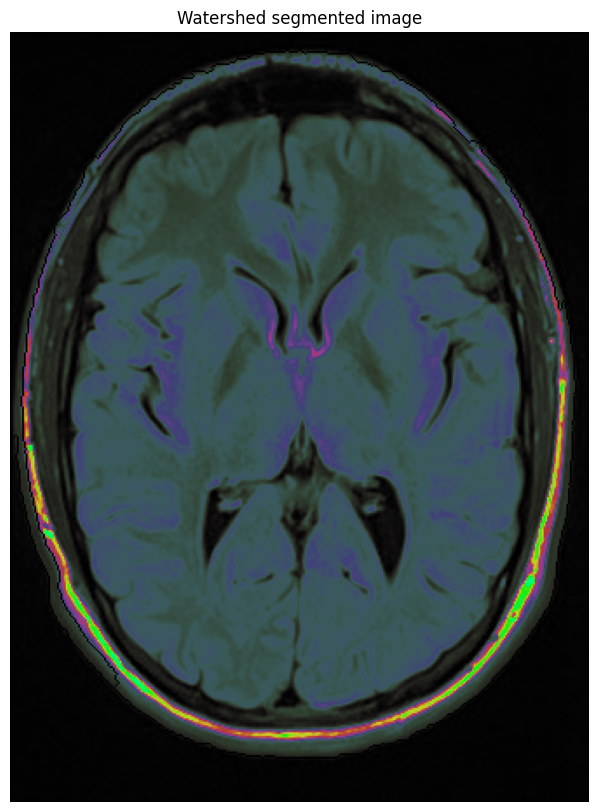

In [ ]:
# CONVERT THE IMAGE FROM HSV TO RGB (IF NEEDED)
im1 = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)

# DISPLAY THE WATERSHED-SEGMENTED IMAGE
ShowImage('Watershed segmented image', im1, 'gray')



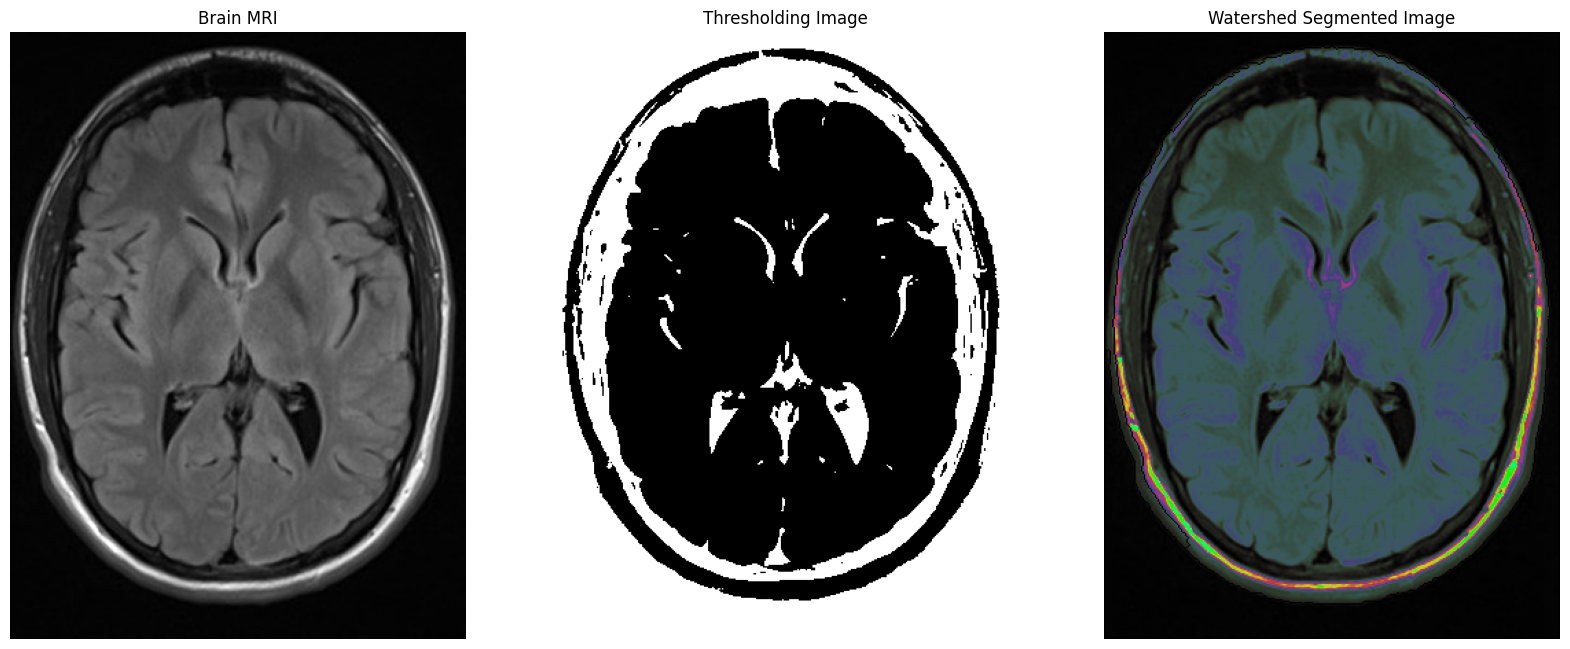

In [ ]:


# CREATE A FIGURE WITH MULTIPLE SUBPLOTS
plt.figure(figsize=(20, 10))

# SUBPLOT 1: DISPLAYING THE GRAYSCALE BRAIN MRI IMAGE
plt.subplot(1, 3, 1)  # 1 ROW, 3 COLUMNS, FIRST POSITION
plt.imshow(gray, cmap='gray')
plt.title('Brain MRI')
plt.axis('off')

# SUBPLOT 2: DISPLAYING THE THRESHOLDED IMAGE
plt.subplot(1, 3, 2)  # 1 ROW, 3 COLUMNS, SECOND POSITION
plt.imshow(thresh, cmap='gray')
plt.title('Thresholding Image')
plt.axis('off')

# SUBPLOT 3: DISPLAYING THE WATERSHED SEGMENTED IMAGE
plt.subplot(1, 3, 3)  # 1 ROW, 3 COLUMNS, THIRD POSITION
plt.imshow(im1, cmap='gray')
plt.title('Watershed Segmented Image')
plt.axis('off')

# SHOW THE COMPARISON
plt.show()


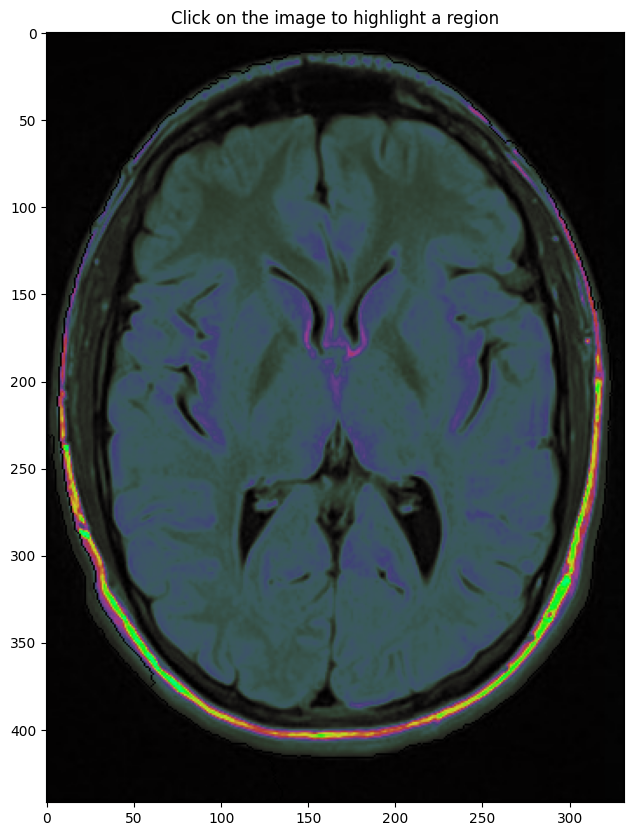

In [ ]:


import matplotlib.pyplot as plt
import cv2

# Function to highlight a clicked pixel region
def on_click(event, img, ax):
    if event.inaxes is not None:
        # Get the x and y coordinates of the clicked point
        x, y = int(event.xdata), int(event.ydata)

        # Define the size of the region to highlight
        size = 20  # Size of the square region around the clicked point

        # Define the rectangle coordinates (top-left and bottom-right corners)
        start_point = (max(x - size, 0), max(y - size, 0))  # Ensure points are within image boundaries
        end_point = (min(x + size, img.shape[1]), min(y + size, img.shape[0]))

        # Draw the rectangle on the image
        img_with_rectangle = img.copy()
        cv2.rectangle(img_with_rectangle, start_point, end_point, (255, 0, 0), 2)

        # Clear the axis and display the updated image
        ax.clear()
        ax.imshow(img_with_rectangle, cmap='gray')
        plt.draw()

# Load and display the image
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(im1, cmap='gray')
plt.title('Click on the image to highlight a region')

# Connect the click event to the function
fig.canvas.mpl_connect('button_press_event', lambda event: on_click(event, im1, ax))

plt.show()
